Using device: cuda
Generation 0: Best fitness = 0.8125
Generation 10: Best fitness = 0.875
Perfect solution found in generation 15


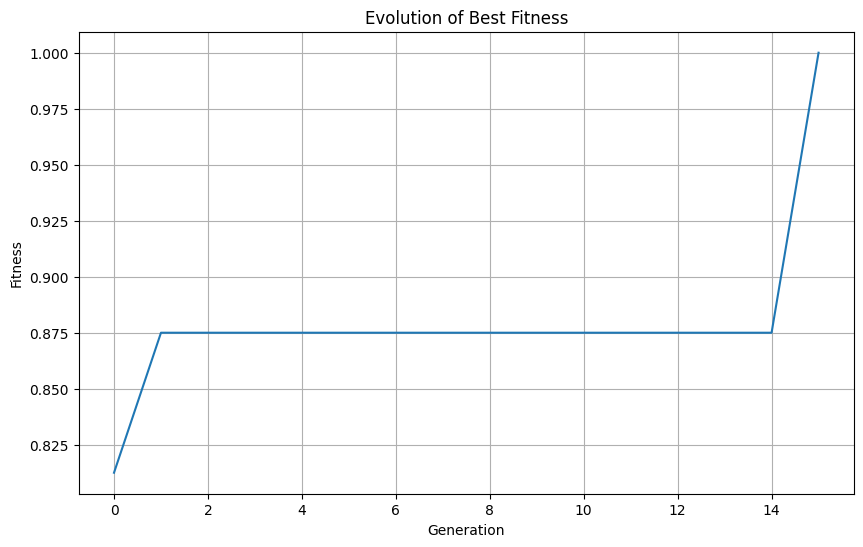


Best circuit found:
Step 1: XOR at (0.5209145242056878, 0.6223796745122635, 0.17033389168606805), inputs: [1, 2]
Step 2: AND at (0.738480941510107, 0.02592092093452425, 0.6126055946225704), inputs: [0, 0]
Step 3: OR at (0.49092929913904293, 0.3930309294554304, 0.7562929584546141), inputs: [0, 1]
Step 4: XOR at (0.3130555063272321, 0.9135800829929762, 0.9070359379375421), inputs: [1, 0]
Step 5: AND at (0.5956386759575301, 0.149422983898714, 0.9997719882081192), inputs: [3, 3]
Step 6: AND at (0.6526763460280798, 0.1785024023599463, 0.16995621883729872), inputs: [2, 3]
Step 7: AND at (0.6908670394098216, 0.2899727361227368, 0.18493091308340526), inputs: [0, 1]
Step 8: OR at (0.40802257565605293, 0.6944467391321134, 0.35513642990374783), inputs: [3, 5]
Step 9: OR at (0.20904228896187282, 0.4433458400306526, 0.3086885305025918), inputs: [7, 6]
Step 10: XOR at (0.78153290500278, 0.6061924428141067, 0.8050704416777483), inputs: [0, 2]
Step 11: OR at (0.6782679959958376, 0.27849863878672754, 

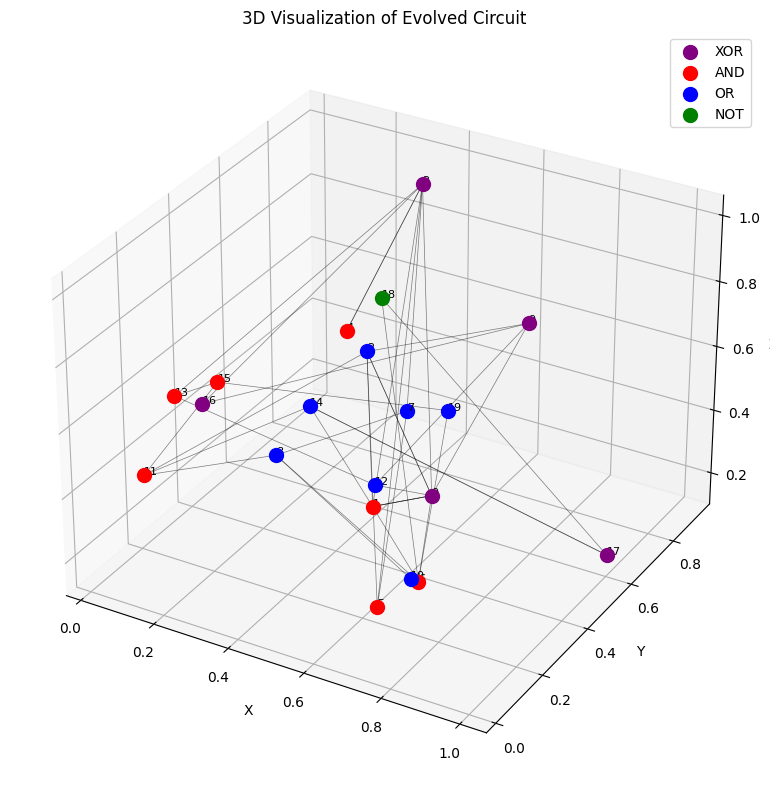

In [8]:
import torch
import random
import numpy as np
import itertools
from typing import List, Tuple, Dict, Callable
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class LogicalOperation:
    def __init__(self, operation: str, coordinate: Tuple[float, float, float], inputs: List[int]):
        self.operation = operation
        self.coordinate = coordinate
        self.inputs = inputs
        self.output = None

class Circuit:
    def __init__(self, operations: List[LogicalOperation], input_map: Dict[int, bool]):
        self.operations = operations
        self.input_map = input_map
        self.fitness = 0.0

class SyntheticAI:
    def __init__(self, population_size: int = 50, mutation_rate: float = 0.2):
        self.logical_ability = torch.tensor([0.0], device=device)
        self.operation_regions = self._initialize_operation_regions()
        self.population_size = population_size
        self.mutation_rate = mutation_rate

    def _initialize_operation_regions(self):
        return {
            "AND": torch.rand(3, device=device),
            "OR": torch.rand(3, device=device),
            "NOT": torch.rand(3, device=device),
            "XOR": torch.rand(3, device=device)
        }

    def train(self):
        self.logical_ability += torch.rand(1, device=device) * 0.01
        self.logical_ability = torch.clamp(self.logical_ability, 0, 1)

    def calculate_operation_affinity(self, operation, coordinate):
        op_region = self.operation_regions[operation]
        coordinate_tensor = torch.tensor(coordinate, device=device)
        distance = torch.norm(op_region - coordinate_tensor)
        affinity = 1 / (1 + distance)
        return affinity.item()

    def execute_operation(self, logical_op: LogicalOperation, circuit: Circuit) -> bool:
        affinity = self.calculate_operation_affinity(logical_op.operation, logical_op.coordinate)
        adjusted_ability = self.logical_ability * (0.5 + affinity)

        input_values = [circuit.input_map[i] if i in circuit.input_map else circuit.operations[i].output for i in logical_op.inputs]

        if logical_op.operation == "AND":
            result = all(input_values)
        elif logical_op.operation == "OR":
            result = any(input_values)
        elif logical_op.operation == "NOT":
            result = not input_values[0]
        elif logical_op.operation == "XOR":
            result = input_values[0] ^ input_values[1]
        else:
            raise ValueError(f"Unknown operation: {logical_op.operation}")

        error = torch.rand(1, device=device) * (1 - adjusted_ability)
        return (result + error.item()) > 0.5

    def evaluate_circuit(self, circuit: Circuit, inputs: List[bool]) -> bool:
        circuit.input_map = {i: inputs[i] for i in range(len(inputs))}
        for op in circuit.operations:
            op.output = self.execute_operation(op, circuit)
        return circuit.operations[-1].output

    def generate_random_circuit(self, num_operations: int, num_inputs: int) -> Circuit:
        operations = []
        input_map = {i: False for i in range(num_inputs)}
        for i in range(num_operations):
            op = random.choice(list(self.operation_regions.keys()))
            coord = tuple(random.random() for _ in range(3))
            if i == 0:
                inputs = [random.randint(0, num_inputs-1) for _ in range(2)]
            else:
                inputs = [random.randint(0, i-1) for _ in range(2)]
            operations.append(LogicalOperation(op, coord, inputs))
        return Circuit(operations, input_map)

    def mutate_circuit(self, circuit: Circuit) -> Circuit:
        new_operations = []
        for i, op in enumerate(circuit.operations):
            if random.random() < self.mutation_rate:
                new_op = random.choice(list(self.operation_regions.keys()))
                new_coord = tuple(random.random() for _ in range(3))
                new_inputs = [random.randint(0, i-1) for _ in range(2)] if i > 0 else [random.randint(0, len(circuit.input_map)-1) for _ in range(2)]
                new_operations.append(LogicalOperation(new_op, new_coord, new_inputs))
            else:
                new_operations.append(op)
        return Circuit(new_operations, circuit.input_map.copy())

    def crossover(self, parent1: Circuit, parent2: Circuit) -> Circuit:
        split_point = random.randint(1, len(parent1.operations) - 1)
        child_operations = parent1.operations[:split_point] + parent2.operations[split_point:]
        child_input_map = parent1.input_map.copy()
        return Circuit(child_operations, child_input_map)

    def evolve_circuit(self, target_function: Callable, generations: int = 100, num_operations: int = 10, num_inputs: int = 4):
        def fitness(circuit):
            correct_outputs = sum(self.evaluate_circuit(circuit, list(inputs)) == target_function(inputs)
                                  for inputs in itertools.product([False, True], repeat=num_inputs))
            return correct_outputs / 2**num_inputs

        population = [self.generate_random_circuit(num_operations, num_inputs) for _ in range(self.population_size)]

        best_fitnesses = []

        for generation in range(generations):
            for circuit in population:
                circuit.fitness = fitness(circuit)

            population.sort(key=lambda x: x.fitness, reverse=True)
            best_circuit = population[0]
            best_fitnesses.append(best_circuit.fitness)

            if best_circuit.fitness == 1.0:
                print(f"Perfect solution found in generation {generation}")
                self.plot_fitness_evolution(best_fitnesses)
                return best_circuit

            new_population = population[:self.population_size // 2]  # Keep top half

            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(population[:self.population_size // 2], 2)
                child = self.crossover(parent1, parent2)
                child = self.mutate_circuit(child)
                new_population.append(child)

            population = new_population

            if generation % 10 == 0:
                print(f"Generation {generation}: Best fitness = {best_circuit.fitness}")

        print("No perfect solution found, returning best circuit")
        self.plot_fitness_evolution(best_fitnesses)
        return population[0]

    def plot_fitness_evolution(self, fitnesses):
        plt.figure(figsize=(10, 6))
        plt.plot(fitnesses)
        plt.title('Evolution of Best Fitness')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.grid(True)
        plt.show()

    def visualize_circuit_3d(self, circuit: Circuit):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Define colors for each operation type
        color_map = {
            "AND": "red",
            "OR": "blue",
            "NOT": "green",
            "XOR": "purple"
        }

        # Plot each operation
        for i, op in enumerate(circuit.operations):
            x, y, z = op.coordinate
            ax.scatter(x, y, z, c=color_map[op.operation], s=100, label=op.operation if op.operation not in ax.get_legend_handles_labels()[1] else "")
            ax.text(x, y, z, f"{i}", fontsize=8)

            # Draw lines to input operations
            for input_idx in op.inputs:
                if input_idx < len(circuit.operations):
                    input_op = circuit.operations[input_idx]
                    ax.plot([x, input_op.coordinate[0]],
                            [y, input_op.coordinate[1]],
                            [z, input_op.coordinate[2]],
                            'k-', linewidth=0.5, alpha=0.5)

        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('3D Visualization of Evolved Circuit')

        # Add legend
        ax.legend()

        # Show the plot
        plt.tight_layout()
        plt.show()

# Example usage
ai = SyntheticAI()

# Train the AI
for _ in range(10000):
    ai.train()

# Define a simpler target function
def target_function(inputs):
    return (inputs[0] and inputs[1]) or (inputs[2] and inputs[3])

# Evolve a circuit for the target function
best_circuit = ai.evolve_circuit(target_function, generations=200, num_operations=20, num_inputs=4)

print("\nBest circuit found:")
for i, op in enumerate(best_circuit.operations):
    print(f"Step {i+1}: {op.operation} at {op.coordinate}, inputs: {op.inputs}")

print(f"\nFinal fitness: {best_circuit.fitness}")
print(f"Logical ability: {ai.logical_ability.item():.4f}")

# Test the best circuit
print("\nTesting the best circuit:")
for inputs in itertools.product([False, True], repeat=4):
    circuit_output = ai.evaluate_circuit(best_circuit, list(inputs))
    expected_output = target_function(inputs)
    print(f"Inputs: {inputs}, Circuit Output: {circuit_output}, Expected Output: {expected_output}")

# Visualize the evolved circuit in 3D
ai.visualize_circuit_3d(best_circuit)